**Problem:** Diagnose diabetic retinopahty patient progression (classification over images of patient's fundus).

Diabetic retinopathy is a condition in which diabetes damages the health of the eyes. It is a major cause of blindness.

**Dataset:** [APTOS 2019 Blindness Detection](https://www.kaggle.com/c/aptos2019-blindness-detection/data)

High-resolution retina images taken under a variety of imaging conditions.

A clinician has rated the presence of diabetic retinopathy in each image on a scale of 0 to 4, according to the following scale:

* 0 - No DR
* 1 - Mild
* 2 - Moderate
* 3 - Severe
* 4 - Proliferative DR

**Dataset split:**

- train images: 3662 images (65.5%)
- test images: 1928 images (34.5%)




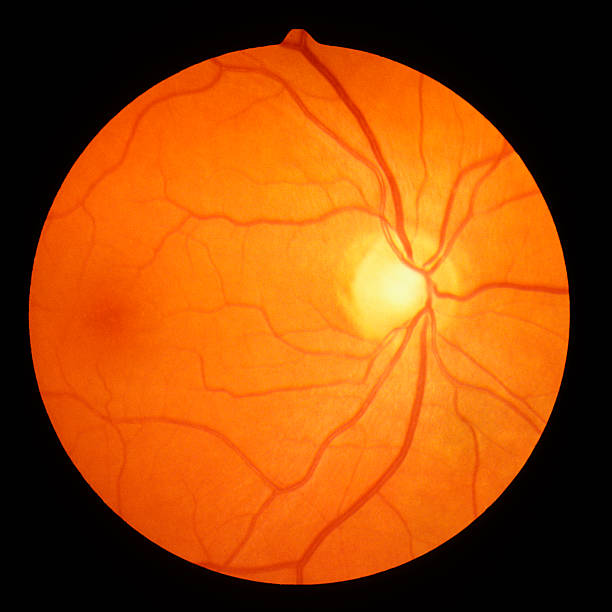

## Setup

**Important**: Need to Activate GPU (runtime type).

### Kaggle

We need to setup API CLI of Kaggle in order to get the dataset.

We are using kaggle data and Google Colab.
Steps below to download and use kaggle data within Google Colab:

1.   We need to create an account on [Kaggle](https://www.kaggle.com/). And need to use our API key of Kaggle.
2.  Go to profile > *Account* (tab) > *API* (section): *Create New API Token*, this will download a .json file (`kaggle.json`) on our computer with our API KEY.



In [ ]:
# Install CLI Kaggle
!pip install -U -q kaggle

In [ ]:
from google.colab import files
# Load your API KEY file
files.upload() # please select your kaggle.json

# Important: Please, clear the output, after completation.

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

### DeepChem

In [ ]:
!pip install --pre deepchem
import deepchem as dc
dc.__version__

## Dataset

In [ ]:
# Downloading data from Kaggle
!mkdir dataset
!kaggle competitions download aptos2019-blindness-detection -p dataset

In [ ]:
# Uncompress the dataset
!unzip "dataset/aptos2019-blindness-detection.zip" -d "dataset"

In [ ]:
# Remove .zip file (dataset)
!rm dataset/aptos2019-blindness-detection.zip

In [ ]:
# Reading csv files for test and train dataset.
# They are both contain names of the images (id_code).

import pandas as pd

test_data = pd.read_csv(r'dataset/test.csv')
train_data = pd.read_csv(r'dataset/train.csv')

print(train_data)

### Resizing images
fx - width, fy - height)

In [ ]:
import cv2

In [ ]:
def resize_image(image_path, img_size=(256, 256)):
  image = cv2.imread(image_path)

  image = cv2.resize(image, (int(img_size[0]), int(img_size[1])))

  cv2.imwrite(image_path, image)


### Creating DeepChem dataset

In [ ]:
import os

import numpy as np

data_dir = os.path.join('dataset', 'train_images')

In [ ]:
images_full_paths = ['{}/{}.png'.format(data_dir, id) for id in train_data['id_code']]
data_mapping = dict(zip(*np.transpose(np.array(train_data))))
labels = np.array(train_data['diagnosis']).reshape((-1, 1))

In [ ]:
print(images_full_paths[:20])
print(labels[:20])

In [ ]:
# resize all images
from tqdm.notebook import tqdm


for image_path in tqdm(images_full_paths):
  resize_image(image_path, img_size=(335, 256))

In [ ]:
# classes and num of instances per class
classes, counts = np.unique(list(data_mapping.values()), return_counts=True)
print(classes, counts) # unbalanced data per class, so we need to define weights

In [ ]:
# We seek to make it up the classes with less data giving a larger weight
weight_ratio = dict(zip(classes, np.max(counts) / counts.astype(float)))
print('Weight ratios: {}'.format(weight_ratio))

# Define weight for each label in labels array
weights = np.array([weight_ratio[label[0]] for label in labels]).reshape((-1, 1))
print(weights[:3])

In [ ]:
# Create DeepChem dataset
dataset = dc.data.ImageDataset(X=images_full_paths, y=labels, w=weights)
# Split
splitter = dc.splits.RandomSplitter()
train_set, valid_set, test_set = splitter.train_valid_test_split(
  dataset=dataset,
  frac_train=0.80,
  frac_valid=0.1,
  frac_test=0.1
)

In [ ]:
print("Train dataset - num instances: ", len(train_set))
print("Valid dataset - num instances: ", len(valid_set))

## Model
We are going to use our defined model (convolutional neural network). URL: https://github.com/riteshrajsharma/Diabetic-Retinopathy-Severity-Classification-Using-Deep-Residual-Learning

In [ ]:
import requests

url = 'https://raw.githubusercontent.com/riteshrajsharma/Diabetic-Retinopathy-Severity-Classification-Using-Deep-Residual-Learning/main/model.py'
answer = requests.get(url)

with open('model.py', 'w') as f:
  f.write(answer.text)

In [ ]:
from model import DRModel, DRAccuracy, ConfusionMatrix, QuadWeightedKappa

In [ ]:
# Create model
image_dims = (256, 335, 3)

model = DRModel(
  n_tasks=1,
  image_dims=image_dims,
  n_init_kernel=32,
  n_classes=len(classes),
  augment=False,
  batch_size=64,
  learning_rate=1e-4
)

In [ ]:
# Metrics,
metrics = [
  # accuracy - percent of labels which are correct
  dc.metrics.Metric(DRAccuracy, mode='classification', classification_handling_mode='direct'),
  # this coefficient is used to measure inter-rater reliability for qualitative items.
  # https://www.kaggle.com/aroraaman/quadratic-kappa-metric-explained-in-5-simple-steps
  dc.metrics.Metric(QuadWeightedKappa, mode='classification', classification_handling_mode='direct')
]

In [ ]:
from tqdm.notebook import trange

# fit (~10 minutes)
num_classes = len(classes)
num_epochs = 30

for x in trange(num_epochs // 10):
  model.fit(train_set, nb_epoch=10)
  print('About to start train metrics evaluation')
  print(model.evaluate(train_set, metrics, n_classes=num_classes))

  print('About to start valid metrics evaluation')
  print(model.evaluate(valid_set, metrics, n_classes=num_classes))


## Performance
Evaluate with test and validation dataset.

### Evaluation

In [ ]:
print('About to start train metrics evaluation')
print(model.evaluate(train_set, metrics, n_classes=num_classes))

print('About to start valid metrics evaluation')
print(model.evaluate(valid_set, metrics, n_classes=num_classes))

print('About to start test metrics evaluation')
print(model.evaluate(test_set, metrics, n_classes=num_classes))

**Note:** In order to get a better result, we can train with more epochs and make tunning.